Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4297 entries, 0 to 4296
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   SettlementValue           4297 non-null   float64
 1   AccidentType              4226 non-null   object 
 2   InjuryPrognosis           4297 non-null   int64  
 3   SpecialHealthExpenses     4297 non-null   float64
 4   SpecialReduction          4297 non-null   float64
 5   SpecialOverage            4297 non-null   float64
 6   GeneralRest               4297 non-null   float64
 7   SpecialAdditionalInjury   4297 non-null   float64
 8   SpecialEarningsLoss       4297 non-null   float64
 9   SpecialUsageLoss          4297 non-null   float64
 10  SpecialMedications        4297 non-null   float64
 11  SpecialAssetDamage        4297 non-null   float64
 12  SpecialRehabilitation     4297 non-null   float64
 13  SpecialFixes              4297 non-null   flo

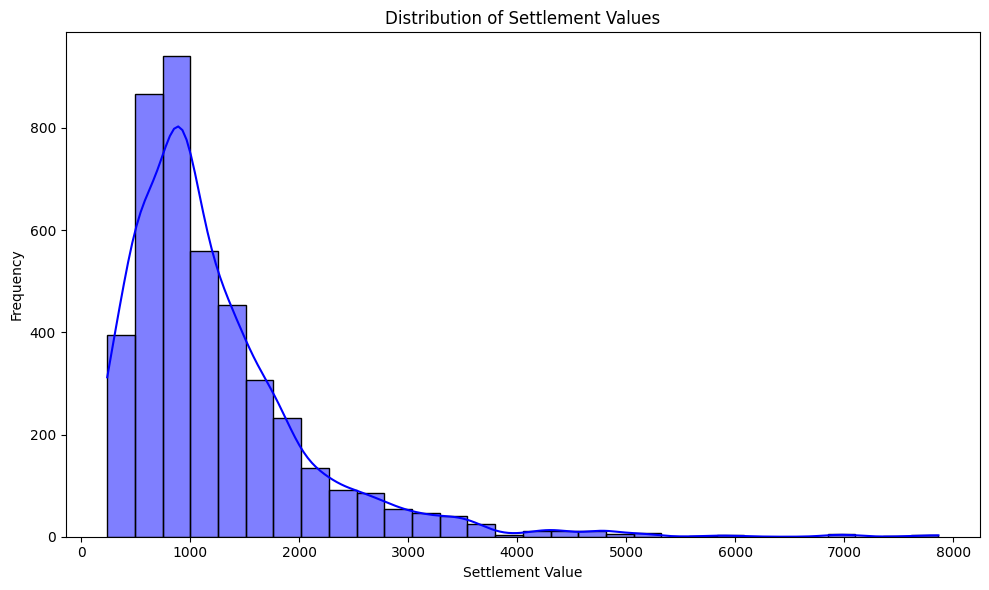

In [1]:
# Import necessary libraries
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from torch.optim.lr_scheduler import CyclicLR
from xgboost import XGBRegressor


# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)


# Load the processed claim data
data_path = 'ProcessedClaimData.csv' 
claim_data = pd.read_csv(data_path)

# Display basic information about the dataset
print("Dataset Overview:")
print(claim_data.info())
print("\nFirst 5 rows of the dataset:")
print(claim_data.head())

# Check for missing values
missing_values = claim_data.isnull().sum()
print("\nMissing values per column:")
print(missing_values[missing_values > 0])

# Basic statistics of numerical columns
print("\nBasic statistics of numerical columns:")
print(claim_data.describe())

# Visualize the distribution of the target variable
target_col = 'SettlementValue'
plt.figure(figsize=(10, 6))
sns.histplot(claim_data[target_col], kde=True, bins=30, color='blue')
plt.title('Distribution of Settlement Values')
plt.xlabel('Settlement Value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Original Settlement Value statistics:
count    4297.000000
mean     1218.505187
std       858.286445
min       240.000000
25%       670.000000
50%       989.000000
75%      1515.000000
max      7862.900000
Name: SettlementValue, dtype: float64

Log-transformed Settlement Value statistics:
count    4297.000000
mean        6.900062
std         0.649392
min         5.484797
25%         6.508769
50%         6.897705
75%         7.323831
max         8.970038
Name: LogSettlementValue, dtype: float64


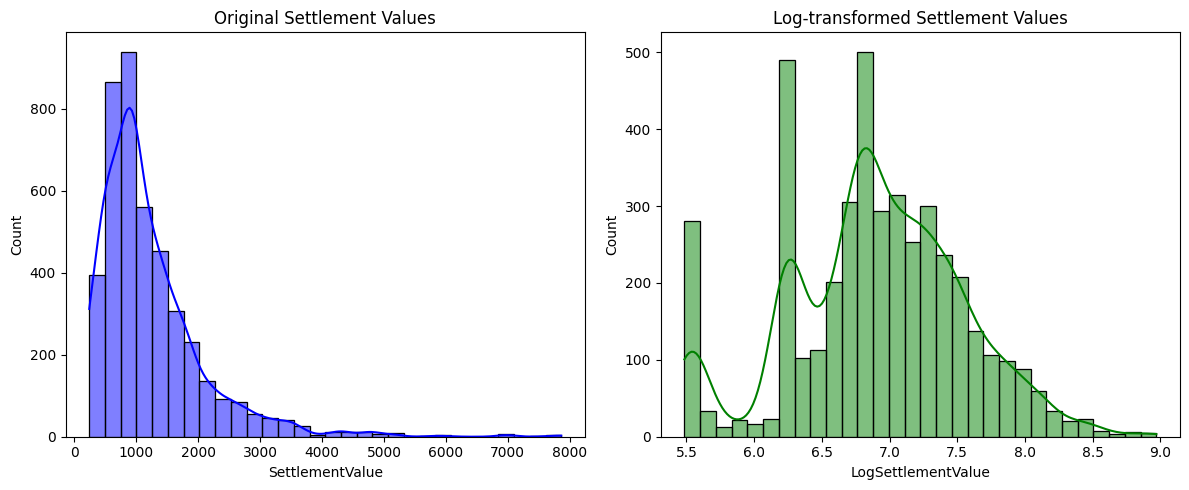

In [2]:
# Apply log transformation to the target variable
claim_data['LogSettlementValue'] = np.log1p(claim_data[target_col])
print("Original Settlement Value statistics:")
print(claim_data[target_col].describe())
print("\nLog-transformed Settlement Value statistics:")
print(claim_data['LogSettlementValue'].describe())

# Update target column to use log-transformed values
original_target_col = target_col
target_col = 'LogSettlementValue'

# Visualize the transformation
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(claim_data[original_target_col], kde=True, bins=30, color='blue')
plt.title('Original Settlement Values')
plt.subplot(1, 2, 2)
sns.histplot(claim_data[target_col], kde=True, bins=30, color='green')
plt.title('Log-transformed Settlement Values')
plt.tight_layout()
plt.show()

In [3]:
# Function to identify categorical and numerical columns (same as model_comparison.ipynb)
def identify_columns(data):
    # Identify categorical and numerical columns
    categorical_cols = data.select_dtypes(include=['object', 'string']).columns.tolist()
    numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    # Remove the target variable from the feature lists
    target_col = 'LogSettlementValue'
    
    # Remove both the log-transformed target AND the original settlement value from features
    if target_col in numerical_cols:
        numerical_cols.remove(target_col)
    if 'SettlementValue' in numerical_cols: 
        numerical_cols.remove('SettlementValue') 
    
    return categorical_cols, numerical_cols, target_col

# Define preprocessor function (similar to model_comparison.ipynb)
def define_preprocessor(data):
    categorical_cols, numerical_cols, _ = identify_columns(data)
    
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),  # Handle missing numerical values with median
        ('scaler', StandardScaler())                    # Standardize numerical features
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing categorical values
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ]
    )
    
    return preprocessor, numerical_cols, categorical_cols

# Get categorical and numerical columns
categorical_cols, numerical_cols, target_col = identify_columns(claim_data)
print(f"\nCategorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")
print(f"Target column: {target_col}")


Categorical columns: ['AccidentType', 'DominantInjury', 'VehicleType', 'WeatherConditions', 'AccidentDescription', 'InjuryDescription', 'Gender']
Numerical columns: ['InjuryPrognosis', 'SpecialHealthExpenses', 'SpecialReduction', 'SpecialOverage', 'GeneralRest', 'SpecialAdditionalInjury', 'SpecialEarningsLoss', 'SpecialUsageLoss', 'SpecialMedications', 'SpecialAssetDamage', 'SpecialRehabilitation', 'SpecialFixes', 'GeneralFixed', 'GeneralUplift', 'SpecialLoanerVehicle', 'SpecialTripCosts', 'SpecialJourneyExpenses', 'SpecialTherapy', 'ExceptionalCircumstances', 'MinorPsychologicalInjury', 'Whiplash', 'AccidentDate', 'ClaimDate', 'VehicleAge', 'DriverAge', 'NumberOfPassengers', 'PoliceReportFiled', 'WitnessPresent']
Target column: LogSettlementValue


# Feature Selection Pipeline: XGBoost vs Random Forest
This section implements a pipeline to compare XGBoost and Random Forest for feature selection, then selects the better performing model for determining the top 10 features.

Start comparing feature selection models...

1. Training and evaluating Random Forest model...
Random Forest MSE: 0.0342 (±0.0063)
Random Forest training time: 13.91 seconds

2. Training and evaluating XGBoost model...
XGBoost MSE: 0.0318 (±0.0044)
XGBoost training time: 0.34 seconds

3. Comparing models:
           Model       MSE       Std  Training Time (s)
0  Random Forest  0.034198  0.006271          13.906196
1        XGBoost  0.031754  0.004385           0.337074

Best model for feature selection: XGBoost


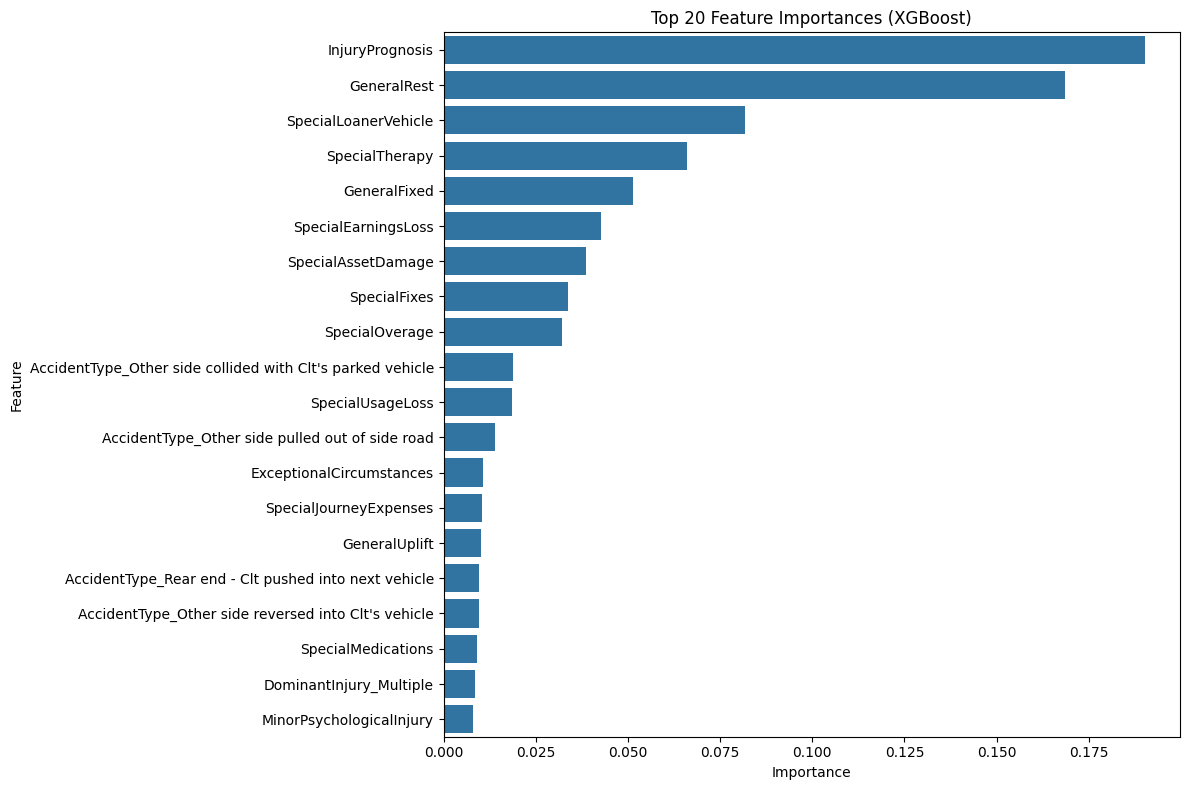


Selected top 10 features using XGBoost:
['InjuryPrognosis' 'GeneralRest' 'SpecialLoanerVehicle' 'SpecialTherapy'
 'GeneralFixed' 'SpecialEarningsLoss' 'SpecialAssetDamage' 'SpecialFixes'
 'SpecialOverage'
 "AccidentType_Other side collided with Clt's parked vehicle"]

Number of common features in top 20: 14 out of 20
Common features: {'SpecialAssetDamage', 'SpecialOverage', 'SpecialEarningsLoss', 'InjuryPrognosis', 'GeneralFixed', 'SpecialFixes', 'AccidentType_Other side pulled out of side road', 'GeneralUplift', 'GeneralRest', 'SpecialJourneyExpenses', 'SpecialLoanerVehicle', 'SpecialUsageLoss', 'MinorPsychologicalInjury', 'SpecialTherapy'}


In [ ]:
# Prepare data for the feature selection models
X = claim_data.drop(columns=[target_col, 'SettlementValue'])
y = claim_data[target_col].values

# Create and fit the preprocessor for features
preprocessor, numerical_cols, categorical_cols = define_preprocessor(claim_data)
X_processed = preprocessor.fit_transform(X)

# Get feature names after preprocessing
feature_names = []
feature_names.extend(numerical_cols)
if categorical_cols:
    ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
    cat_feature_names = ohe.get_feature_names_out(categorical_cols)
    feature_names.extend(cat_feature_names)

print("Start comparing feature selection models...")

# Define cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# 1. Train and evaluate Random Forest
print("\n1. Training and evaluating Random Forest model...")
start_time_rf = time.time()
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Cross-validation for Random Forest
rf_scores = cross_val_score(rf_model, X_processed, y, cv=cv, scoring='neg_mean_squared_error')
rf_mse = -rf_scores.mean()
rf_std = rf_scores.std()

# Fit Random Forest on the full dataset for feature importance
rf_model.fit(X_processed, y)
rf_importances = rf_model.feature_importances_
end_time_rf = time.time()
rf_time = end_time_rf - start_time_rf

# Create a DataFrame for Random Forest feature importances
rf_feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_importances
}).sort_values('Importance', ascending=False)

print(f"Random Forest MSE: {rf_mse:.4f} (±{rf_std:.4f})")
print(f"Random Forest training time: {rf_time:.2f} seconds")

# 2. Train and evaluate XGBoost
print("\n2. Training and evaluating XGBoost model...")
start_time_xgb = time.time()
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Cross-validation for XGBoost
xgb_scores = cross_val_score(xgb_model, X_processed, y, cv=cv, scoring='neg_mean_squared_error')
xgb_mse = -xgb_scores.mean()
xgb_std = xgb_scores.std()

# Fit XGBoost on the full dataset for feature importance
xgb_model.fit(X_processed, y)
xgb_importances = xgb_model.feature_importances_
end_time_xgb = time.time()
xgb_time = end_time_xgb - start_time_xgb

# Create a DataFrame for XGBoost feature importances
xgb_feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_importances
}).sort_values('Importance', ascending=False)

print(f"XGBoost MSE: {xgb_mse:.4f} (±{xgb_std:.4f})")
print(f"XGBoost training time: {xgb_time:.2f} seconds")

# 3. Compare the models and select the better one
model_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost'],
    'MSE': [rf_mse, xgb_mse],
    'Std': [rf_std, xgb_std],
    'Training Time (s)': [rf_time, xgb_time]
})
print("\n3. Comparing models:")
print(model_comparison)

# Determine the better model based on MSE
best_model_name = model_comparison.loc[model_comparison['MSE'].idxmin(), 'Model']
print(f"\nBest model for feature selection: {best_model_name}")

# Select the feature importance from the better model
if best_model_name == 'Random Forest':
    best_feature_importance = rf_feature_importance
    model_name_short = 'RF'
else:
    best_feature_importance = xgb_feature_importance
    model_name_short = 'XGB'

# Visualize the top 20 features from the better model
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=best_feature_importance.head(20))
plt.title(f'Top 20 Feature Importances ({best_model_name})')
plt.tight_layout()
plt.show()

# Select the top 10 features from the better model
top_10_features = best_feature_importance.head(10)['Feature'].values
print(f"\nSelected top 10 features using {best_model_name}:")
print(top_10_features)

# Compare feature rankings between the two models
# Get top 20 features from each model
rf_top20 = rf_feature_importance.head(20)['Feature'].tolist()
xgb_top20 = xgb_feature_importance.head(20)['Feature'].tolist()

# Count features in both lists (common features)
common_features = set(rf_top20).intersection(set(xgb_top20))
print(f"\nNumber of common features in top 20: {len(common_features)} out of 20")
print("Common features:", common_features)

# Get the indices of the top 10 features in the processed data
top_10_indices = [i for i, feature in enumerate(feature_names) if feature in top_10_features]

# Save the feature selection results
feature_selection_results = {
    'best_model': best_model_name,
    'rf_mse': rf_mse,
    'xgb_mse': xgb_mse,
    'top_10_features': top_10_features.tolist(), 
    'top_10_indices': top_10_indices,
    'common_features_in_top20': list(common_features)
}

# Prepare Data for PyTorch
Now that we have identified the top 10 features, we'll split the data into training, validation, and test sets and prepare it for neural network training.

In [5]:
# Split the data into training, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Apply preprocessing to the data
X_train_processed = preprocessor.transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

# Filter to include only the top 10 features selected by the best model
X_train_processed_top10 = X_train_processed[:, top_10_indices]
X_val_processed_top10 = X_val_processed[:, top_10_indices]
X_test_processed_top10 = X_test_processed[:, top_10_indices]

# Convert to PyTorch tensors using the selected top 10 features
X_train_tensor = torch.tensor(X_train_processed_top10, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val_processed_top10, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_processed_top10, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create DataLoader objects for PyTorch

batch_size = 48
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset sizes and shapes with top 10 features
print(f"\nTraining set size: {len(train_dataset)} samples, Features shape (top 10): {X_train_processed_top10.shape}")
print(f"Validation set size: {len(val_dataset)} samples, Features shape (top 10): {X_val_processed_top10.shape}")
print(f"Test set size: {len(test_dataset)} samples, Features shape (top 10): {X_test_processed_top10.shape}")


Training set size: 2577 samples, Features shape (top 10): (2577, 10)
Validation set size: 860 samples, Features shape (top 10): (860, 10)
Test set size: 860 samples, Features shape (top 10): (860, 10)


# Build and Train Neural Network Model
Implement a PyTorch neural network model for regression using the top 10 features with early stopping.

In [6]:
class AutoClusterWeightedLoss(nn.Module):
    def __init__(self, mse_weight=0.6, huber_weight=0.3, mae_weight=0.1, delta=0.8, 
                 num_clusters=3, cluster_weights=None):
        super(AutoClusterWeightedLoss, self).__init__()
        self.mse_weight = mse_weight
        self.huber_weight = huber_weight
        self.mae_weight = mae_weight
        self.delta = delta
        
        # Number of clusters (default: 3 - low, medium, high)
        self.num_clusters = num_clusters
        
        # Default progressively higher weights for higher clusters
        if cluster_weights is None:
            # Generate weights that increase for higher-valued clusters
            self.cluster_weights = [1.0 + 0.75 * i for i in range(num_clusters)]
        else:
            self.cluster_weights = cluster_weights
            
        # Thresholds will be determined automatically from data
        self.thresholds = None
        
    def fit_clusters(self, target_values):
        """
        Determine cluster thresholds based on data quantiles
        """
        if isinstance(target_values, torch.Tensor):
            target_values = target_values.detach().cpu().numpy()
            
        # Calculate quantiles for even spacing between clusters
        quantiles = [float(i) / self.num_clusters for i in range(1, self.num_clusters)]
        
        # Set thresholds at these quantiles
        self.thresholds = np.quantile(target_values, quantiles)
        return self
        
    def forward(self, predictions, targets):
        if self.thresholds is None:
            raise ValueError("Cluster thresholds not set. Call fit_clusters before using.")
            
        # Base losses
        mse_loss = torch.square(predictions - targets)
        huber_loss = torch.nn.functional.huber_loss(
            predictions, targets, reduction='none', delta=self.delta
        )
        mae_loss = torch.abs(predictions - targets)
        
        # Combine with loss type weights
        base_loss = (
            self.mse_weight * mse_loss + 
            self.huber_weight * huber_loss + 
            self.mae_weight * mae_loss
        )
        
        # Apply cluster-based weighting
        weights = torch.ones_like(targets)
        
        # First cluster
        mask = targets <= self.thresholds[0]
        weights[mask] = self.cluster_weights[0]
        
        # Middle clusters
        for i in range(1, self.num_clusters-1):
            mask = (targets > self.thresholds[i-1]) & (targets <= self.thresholds[i])
            weights[mask] = self.cluster_weights[i]
        
        # Last cluster (highest values)
        mask = targets > self.thresholds[-1]
        weights[mask] = self.cluster_weights[-1]
        
        # Apply weights to the base loss
        weighted_loss = base_loss * weights
        
        return weighted_loss.mean()


class ClusterWeightedLoss(nn.Module):
    def __init__(self, mse_weight=0.6, huber_weight=0.3, mae_weight=0.1, delta=0.8):
        super(ClusterWeightedLoss, self).__init__()
        self.mse_weight = mse_weight
        self.huber_weight = huber_weight
        self.mae_weight = mae_weight
        self.delta = delta
        
        # Define cluster boundaries in log space
        # Low: <£1000 (~6.9), Mid: £1000-£3000 (~8.0), High: >£3000
        self.thresholds = [6.9, 8.0]  
        
        # Define weights for different value ranges
        self.low_weight = 1.0    # <£1000
        self.mid_weight = 1.5    # £1000-£3000
        self.high_weight = 2.5   # >£3000
        
    def forward(self, predictions, targets):
        # Base losses
        mse_loss = torch.square(predictions - targets)
        huber_loss = torch.nn.functional.huber_loss(
            predictions, targets, reduction='none', delta=self.delta
        )
        mae_loss = torch.abs(predictions - targets)
        
        # Combine with loss type weights
        base_loss = (
            self.mse_weight * mse_loss + 
            self.huber_weight * huber_loss + 
            self.mae_weight * mae_loss
        )
        
        # Apply cluster-based weighting
        weights = torch.ones_like(targets)
        
        # Low value claims (<£1000)
        low_mask = targets <= self.thresholds[0]
        weights[low_mask] = self.low_weight
        
        # Mid value claims (£1000-£3000)
        mid_mask = (targets > self.thresholds[0]) & (targets <= self.thresholds[1])
        weights[mid_mask] = self.mid_weight
        
        # High value claims (>£3000)
        high_mask = targets > self.thresholds[1]
        weights[high_mask] = self.high_weight
        
        # Apply even higher weight for extreme outliers (>£5000)
        extreme_mask = targets > 8.5  # ~£5000 in log space
        weights[extreme_mask] *= 1.3
        
        # Apply weights to the base loss
        weighted_loss = base_loss * weights
        
        return weighted_loss.mean()

In [ ]:
def grid_search_auto_cluster_loss(model, train_loader, val_loader, device, epochs_per_combo=25):
    """
    Grid search for AutoClusterWeightedLoss hyperparameters
    Returns the best loss function and its parameters
    """
    # Collect all training targets to fit the clusters
    train_targets = []
    for _, y_batch in train_loader:
        train_targets.append(y_batch)
    train_targets = torch.cat(train_targets, dim=0)
    
    # Define parameter grid
    param_grid = {
        'mse_weight': [0.5, 0.6, 0.7],
        'huber_weight': [0.2, 0.3, 0.4],
        'delta': [0.6, 0.8, 1.0],
    }
    
    # Different cluster configurations to try
    cluster_configs = [
        {'num_clusters': 3, 'cluster_weights': [1.0, 1.75, 2.5]},
        {'num_clusters': 3, 'cluster_weights': [0.8, 1.7, 3.0]},
        {'num_clusters': 4, 'cluster_weights': [0.8, 1.3, 2.0, 2.8]},
        {'num_clusters': 5, 'cluster_weights': [0.8, 1.3, 2.0, 2.8]},
    ]
    
    # Generate parameter combinations more efficiently
    combinations = []
    for mse_w in param_grid['mse_weight']:
        for huber_w in param_grid['huber_weight']:
            mae_w = max(0, round(1.0 - mse_w - huber_w, 3))
            if mae_w <= 0.3:  # Ensure reasonable mae_weight
                for delta in param_grid['delta']:
                    for cluster_config in cluster_configs:
                        combinations.append({
                            'mse_weight': mse_w,
                            'huber_weight': huber_w,
                            'mae_weight': mae_w,
                            'delta': delta,
                            'num_clusters': cluster_config['num_clusters'],
                            'cluster_weights': cluster_config['cluster_weights'],
                        })
    
    # Storage for results
    results = []
    best_val_loss = float('inf')
    best_params = None
    best_criterion = None
    
    # Create a deep copy of the initial model state
    initial_model_state = copy.deepcopy(model.state_dict())
    
    print(f"Grid searching through {len(combinations)} parameter combinations...")
    
    # Track progress
    total_combinations = len(combinations)
    
    for i, params in enumerate(combinations):
        print(f"\nCombination {i+1}/{total_combinations}")
        print(f"Parameters: mse={params['mse_weight']}, huber={params['huber_weight']}, "
              f"mae={params['mae_weight']:.3f}, delta={params['delta']}, "
              f"clusters={params['num_clusters']}")
        
        # Reset model to initial state
        model.load_state_dict(copy.deepcopy(initial_model_state))
        
        # Create criterion with current parameters
        criterion = AutoClusterWeightedLoss(
            mse_weight=params['mse_weight'],
            huber_weight=params['huber_weight'],
            mae_weight=params['mae_weight'],
            delta=params['delta'],
            num_clusters=params['num_clusters'],
            cluster_weights=params['cluster_weights']
        ).to(device)
        
        # Fit the clusters on the training data
        criterion.fit_clusters(train_targets)
        print(f"Cluster thresholds: {criterion.thresholds}")
        
        # Create optimizer
        optimizer = optim.Adam(model.parameters(), lr=0.0008, weight_decay=1e-5)
        
        # Train for a few epochs
        best_combo_val_loss = float('inf')
        
        for epoch in range(epochs_per_combo):
            # Training phase
            model.train()
            train_loss = 0.0
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                
                # Forward pass
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                
                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=3.0)
                optimizer.step()
                
                train_loss += loss.item() * X_batch.size(0)
            
            train_loss /= len(train_loader.dataset)
            
            # Validation phase
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                    predictions = model(X_batch)
                    loss = criterion(predictions, y_batch)
                    val_loss += loss.item() * X_batch.size(0)
                    
            val_loss /= len(val_loader.dataset)
            
            if (epoch + 1) % 5 == 0 or epoch == 0:  # Print only every 5 epochs to reduce output
                print(f"Epoch {epoch+1}/{epochs_per_combo}, "
                      f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
            
            best_combo_val_loss = min(best_combo_val_loss, val_loss)
        
        # Store results for this combination
        params_with_result = params.copy()
        params_with_result['val_loss'] = best_combo_val_loss
        results.append(params_with_result)
        
        # Update best parameters if this combination is better
        if best_combo_val_loss < best_val_loss:
            best_val_loss = best_combo_val_loss
            best_params = params.copy()
            # Create a copy of the best criterion
            best_criterion = AutoClusterWeightedLoss(
                mse_weight=params['mse_weight'],
                huber_weight=params['huber_weight'],
                mae_weight=params['mae_weight'],
                delta=params['delta'],
                num_clusters=params['num_clusters'],
                cluster_weights=params['cluster_weights']
            ).to(device)
            best_criterion.fit_clusters(train_targets)
            print(f"New best parameters found! Val Loss: {best_val_loss:.4f}")
    
    # Sort results by validation loss
    results.sort(key=lambda x: x['val_loss'])
    
    print("\nGrid search complete!")
    print("Best parameters:")
    for key, value in best_params.items():
        print(f"  {key}: {value}")
    print(f"Best validation loss: {best_val_loss:.4f}")
    
    # Reset model to initial state
    model.load_state_dict(copy.deepcopy(initial_model_state))
    
    return best_criterion, best_params, results

Using device: cpu
Starting grid search for optimal loss function parameters...
Starting grid search for optimal loss function parameters...
Grid searching through 108 parameter combinations...

Combination 1/108
Parameters: mse=0.5, huber=0.2, mae=0.300, delta=0.6, clusters=3
  Cluster thresholds: [6.73050086 7.18009456]
    Epoch 1/25, Train Loss: 19.7715, Val Loss: 3.1134
    Epoch 5/25, Train Loss: 0.5038, Val Loss: 0.3310
    Epoch 10/25, Train Loss: 0.3164, Val Loss: 0.1945
    Epoch 15/25, Train Loss: 0.2591, Val Loss: 0.1486
    Epoch 20/25, Train Loss: 0.2135, Val Loss: 0.1708
    Epoch 25/25, Train Loss: 0.1808, Val Loss: 0.1426
  New best parameters found! Val Loss: 0.1360

Combination 2/108
Parameters: mse=0.5, huber=0.2, mae=0.300, delta=0.6, clusters=3
  Cluster thresholds: [6.73050086 7.18009456]
    Epoch 1/25, Train Loss: 20.8914, Val Loss: 3.0904
    Epoch 5/25, Train Loss: 0.5651, Val Loss: 0.2699
    Epoch 10/25, Train Loss: 0.3294, Val Loss: 0.2960
    Epoch 15/25, 

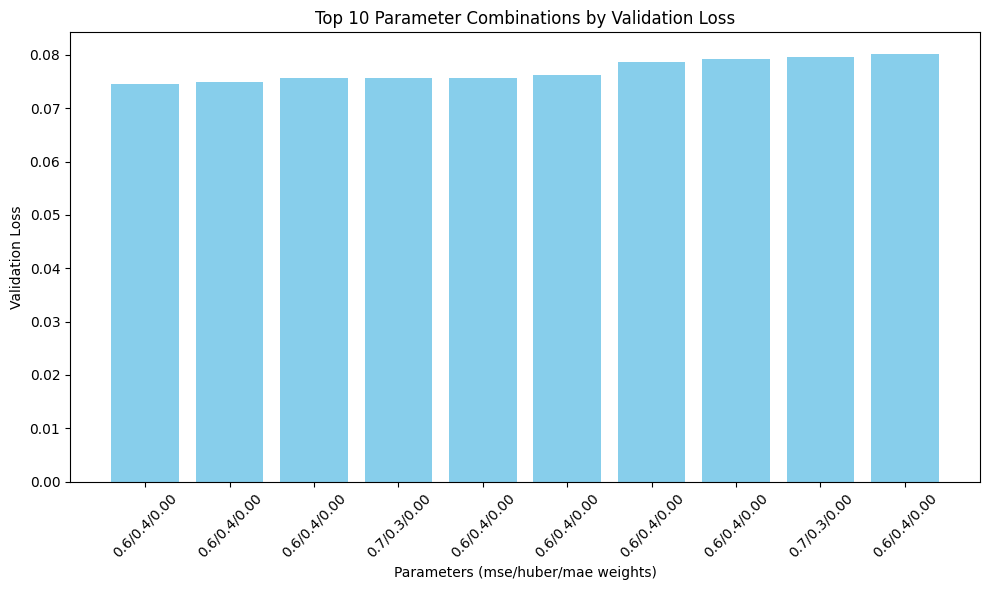


Best loss function parameters:
  mse_weight: 0.6
  huber_weight: 0.4
  mae_weight: 0
  delta: 0.8
  num_clusters: 4
  cluster_weights: [0.8, 1.3, 2.0, 2.8]
Epoch 1/200, Train Loss: 37.5469, Val Loss: 16.3774
  Found new best model with validation loss: 16.3774 (improved by 0.00%)
Epoch 2/200, Train Loss: 2.2849, Val Loss: 1.2239
  Found new best model with validation loss: 1.2239 (improved by 92.53%)
Epoch 3/200, Train Loss: 0.9139, Val Loss: 0.5503
  Found new best model with validation loss: 0.5503 (improved by 55.03%)
Epoch 4/200, Train Loss: 0.7851, Val Loss: 0.5635
Epoch 5/200, Train Loss: 0.6424, Val Loss: 0.3966
  Found new best model with validation loss: 0.3966 (improved by 27.93%)
Epoch 6/200, Train Loss: 0.5522, Val Loss: 0.3503
  Found new best model with validation loss: 0.3503 (improved by 11.69%)
Epoch 7/200, Train Loss: 0.5059, Val Loss: 0.4927
Epoch 8/200, Train Loss: 0.4316, Val Loss: 0.2816
  Found new best model with validation loss: 0.2816 (improved by 19.59%)
Epo

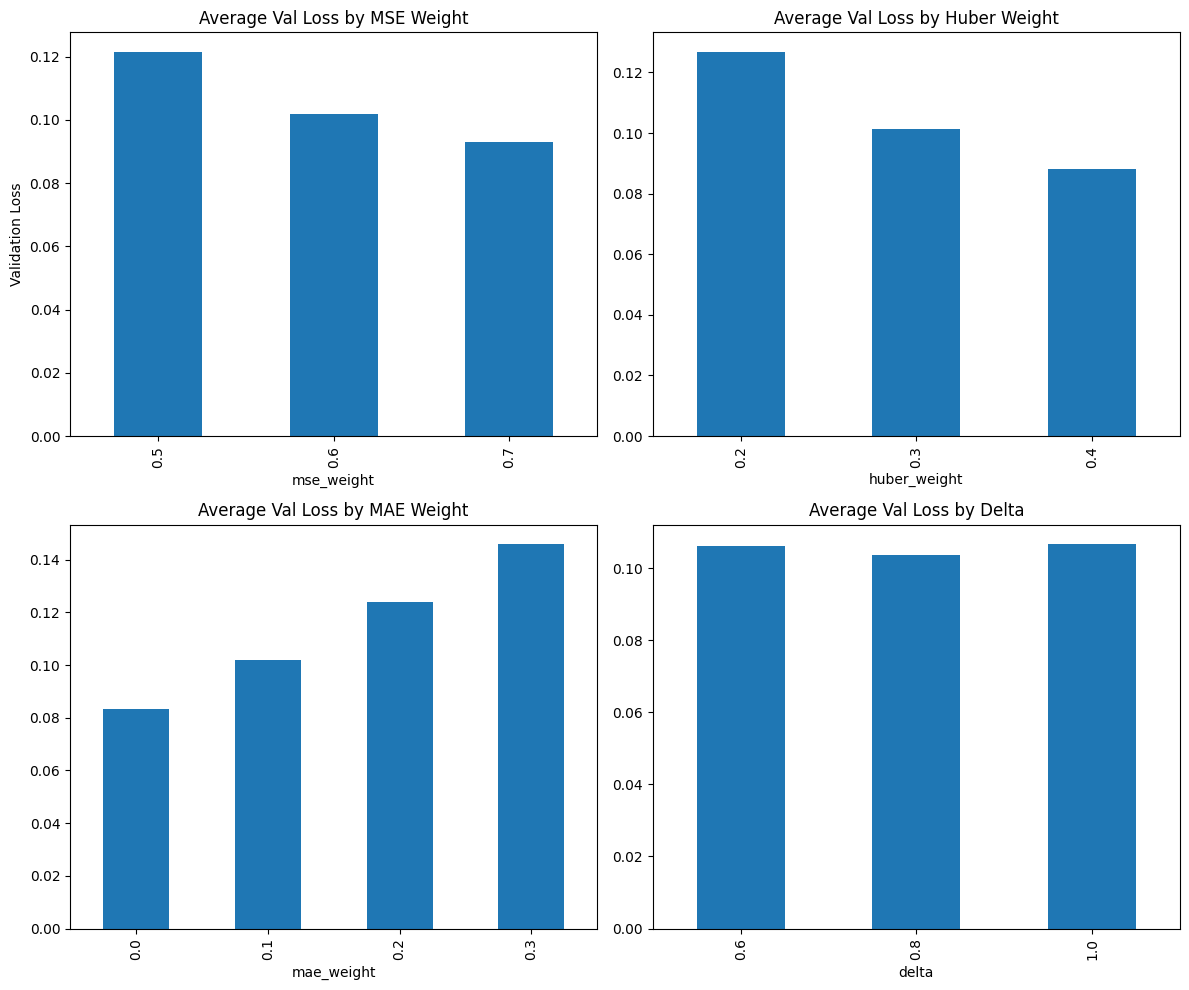

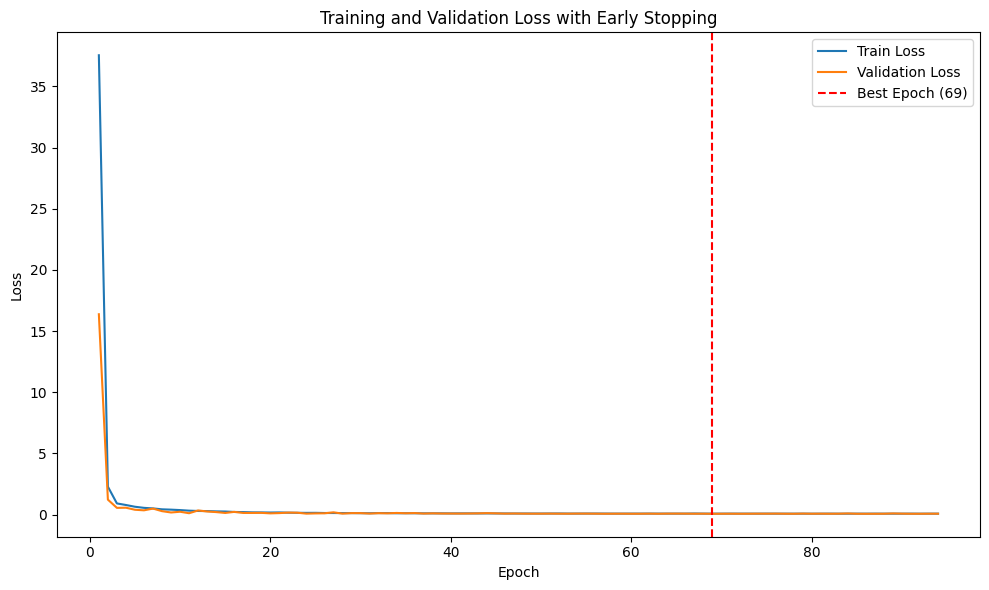

In [ ]:
# Define the PyTorch neural network model for top 10 features
# More balanced neural network that avoids over-correction
# Check if MPS (Metal Performance Shaders) backend is available for Apple Silicon
device = torch.device("cpu" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Neural network with slight improvements to capture high-value claims better
class InsuranceNN(nn.Module):
    def __init__(self, input_size):
        super(InsuranceNN, self).__init__()
        
        # Main network path
        self.input_layer = nn.Linear(input_size, 128)  # Wider first layer
        self.bn1 = nn.BatchNorm1d(128)
        self.hidden1 = nn.Linear(128, 96)
        self.bn2 = nn.BatchNorm1d(96)
        self.hidden2 = nn.Linear(96, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.hidden3 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)
        
        # Specialized branches with increased capacity for value ranges
        self.low_value_net = nn.Sequential(
            nn.Linear(32, 24),
            nn.LeakyReLU(0.1),
            nn.Linear(24, 16)
        )
        
        self.mid_value_net = nn.Sequential(
            nn.Linear(32, 32),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Linear(32, 16)
        )
        
        self.high_value_net = nn.Sequential(
            nn.Linear(32, 64),  # Increased from 48 to 64
            nn.LeakyReLU(0.1),
            nn.Dropout(0.25),
            nn.Linear(64, 48),  # New intermediate layer
            nn.LeakyReLU(0.1),
            nn.Linear(48, 32),
            nn.LeakyReLU(0.1),
            nn.Linear(32, 16)
        )

        # Shared features from main network
        self.shared_features = nn.Linear(32, 16)
        
        # Combine all branches plus original features for residual connection
        self.final = nn.Linear(input_size + 64, 1)
        
    def forward(self, x):
        # Main network with leaky ReLU and dropout
        h1 = nn.functional.leaky_relu(self.bn1(self.input_layer(x)), 0.1)
        h1 = nn.functional.dropout(h1, p=0.2, training=self.training)
        
        h2 = nn.functional.leaky_relu(self.bn2(self.hidden1(h1)), 0.1)
        h2 = nn.functional.dropout(h2, p=0.2, training=self.training)
        
        h3 = nn.functional.leaky_relu(self.bn3(self.hidden2(h2)), 0.1)
        h3 = nn.functional.dropout(h3, p=0.1, training=self.training)
        
        h4 = nn.functional.leaky_relu(self.bn4(self.hidden3(h3)), 0.1)
        
        # Branch networks
        low_features = self.low_value_net(h4)
        mid_features = self.mid_value_net(h4)
        high_features = self.high_value_net(h4)
        shared_features = self.shared_features(h4)
    
        
        # Combine features including original input (residual connection)
        combined = torch.cat([low_features, mid_features, high_features, shared_features, x], dim=1)
        prediction = self.final(combined)
        high_value_indicator = torch.sigmoid(prediction - 7.0)  # 7.0 is ~1100 GBP in log space
        correction = high_value_indicator * 0.05  # Small positive adjustment for high values
    
        return prediction + correction  # This helps counteract the underestimation 
      
# Initialize the model
# Define the model with the same architecture (no changes needed)
input_size = X_train_tensor.shape[1]
model = InsuranceNN(input_size).to(device)

# # Use the new cluster-aware loss function
# criterion = AdaptiveRobustMSELoss().to(device)

# # Keep the same optimizer but slightly adjust learning rate
# optimizer = optim.Adam(model.parameters(), lr=0.0008, weight_decay=1e-5)


initial_model_state = copy.deepcopy(model.state_dict())

# Create batch sizes for grid search (smaller) and full training
grid_batch_size = 32
train_batch_size = 24

# Create DataLoader objects for grid search
grid_train_loader = DataLoader(train_dataset, batch_size=grid_batch_size, shuffle=True)
grid_val_loader = DataLoader(val_dataset, batch_size=grid_batch_size, shuffle=False)


print("Starting grid search for optimal loss function parameters...")

# Collect all training targets for cluster fitting
train_targets = torch.cat([y for _, y in train_loader], dim=0)

best_criterion, best_params, grid_results = grid_search_auto_cluster_loss(
    model, grid_train_loader, grid_val_loader, device, epochs_per_combo=25
)

model.load_state_dict(copy.deepcopy(initial_model_state))
optimizer = optim.Adam(model.parameters(), lr=0.0008, weight_decay=1e-5)


# Setup learning rate scheduler
scheduler = CyclicLR(
    optimizer,
    base_lr=0.0003,
    max_lr=0.0015,
    step_size_up=10 * len(train_loader),
    mode='triangular2',
    cycle_momentum=False
)

# Plot grid search results
plt.figure(figsize=(10, 6))
plt.bar(
    range(len(grid_results[:10])), 
    [r['val_loss'] for r in grid_results[:10]],
    color='skyblue'
)
plt.xticks(
    range(len(grid_results[:10])), 
    [f"{r['mse_weight']}/{r['huber_weight']}/{r['mae_weight']:.2f}" for r in grid_results[:10]],
    rotation=45
)
plt.title('Top 10 Parameter Combinations by Validation Loss')
plt.xlabel('Parameters (mse/huber/mae weights)')
plt.ylabel('Validation Loss')
plt.tight_layout()
plt.show()

# Print the best parameters found
print("\nBest loss function parameters:")
for param, value in best_params.items():
    print(f"  {param}: {value}")
    
# Lower and more effective batch size for this dataset
batch_size = 24
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training settings
num_epochs = 200  # Slightly more epochs
early_stopping_patience = 25
best_val_loss = float('inf')
patience_counter = 0
train_losses = []
val_losses = []
best_epoch = 0

# Training loop with early stopping
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        predictions = model(X_batch)
        loss = best_criterion(predictions, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        
        # Gentle gradient clipping 
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=3.0)
        
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch)
            loss = best_criterion(predictions, y_batch)
            val_loss += loss.item() * X_batch.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    
    # Update learning rate
    scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping logic with best model tracking
    if val_loss < best_val_loss:
        improvement = (best_val_loss - val_loss) / best_val_loss * 100 if best_val_loss != float('inf') else 0
        best_val_loss = val_loss
        best_epoch = epoch + 1
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        print(f"  Found new best model with validation loss: {val_loss:.4f} (improved by {improvement:.2f}%)")
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping triggered. Best epoch was {best_epoch}")
            break

# Load the best model
print("\nLoading best model from checkpoint...")
model.load_state_dict(best_model_state)


# Convert results to DataFrame
grid_df = pd.DataFrame(grid_results)

# Print best combination details
best_combo = grid_df.iloc[0]
print("\nBest Loss Function Parameters:")
print(f"MSE Weight: {best_combo['mse_weight']}")
print(f"Huber Weight: {best_combo['huber_weight']}")
print(f"MAE Weight: {best_combo['mae_weight']}")
print(f"Delta: {best_combo['delta']}")
print(f"Validation Loss: {best_combo['val_loss']:.6f}")

# Save to CSV (optional)
# grid_df.to_csv('loss_param_grid_search_results.csv', index=False)

# Visualize grid search results in more detail
plt.figure(figsize=(12, 10))

# Create subplots for each parameter
plt.subplot(2, 2, 1)
grid_df.groupby('mse_weight')['val_loss'].mean().plot(kind='bar')
plt.title('Average Val Loss by MSE Weight')
plt.ylabel('Validation Loss')

plt.subplot(2, 2, 2)
grid_df.groupby('huber_weight')['val_loss'].mean().plot(kind='bar')
plt.title('Average Val Loss by Huber Weight')

plt.subplot(2, 2, 3)
grid_df.groupby('mae_weight')['val_loss'].mean().plot(kind='bar')
plt.title('Average Val Loss by MAE Weight')

plt.subplot(2, 2, 4)
grid_df.groupby('delta')['val_loss'].mean().plot(kind='bar')
plt.title('Average Val Loss by Delta')

plt.tight_layout()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Epoch ({best_epoch})')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss with Early Stopping")
plt.legend()
plt.tight_layout()
plt.show()

Test Loss (MSE in log space): 0.0766
Test R² (in log space): 0.8680


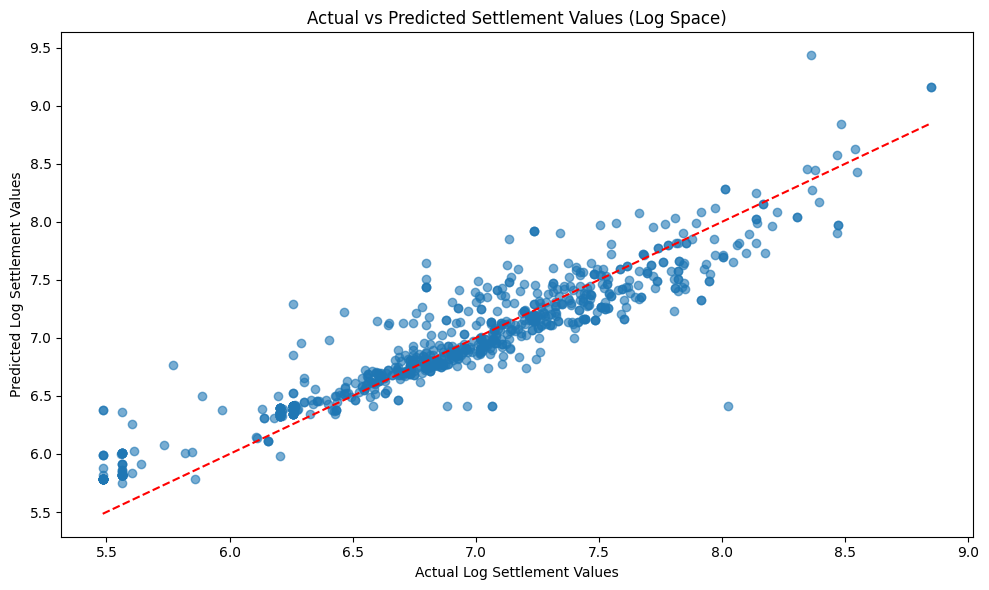

In [9]:
# Evaluate the model on the test set in log space
model.eval()
test_loss = 0.0
predictions_list = []
actuals_list = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        predictions = model(X_batch)
        loss = best_criterion(predictions, y_batch)
        test_loss += loss.item() * X_batch.size(0)

        predictions_list.extend(predictions.cpu().numpy())
        actuals_list.extend(y_batch.cpu().numpy())

test_loss /= len(test_loader.dataset)
test_r2 = r2_score(actuals_list, predictions_list)
print(f"Test Loss (MSE in log space): {test_loss:.4f}")
print(f"Test R² (in log space): {test_r2:.4f}")


# Plot actual vs predicted values in log space
plt.figure(figsize=(10, 6))
plt.scatter(actuals_list, predictions_list, alpha=0.6)
plt.plot([min(actuals_list), max(actuals_list)], [min(actuals_list), max(actuals_list)], 'r--')
plt.xlabel("Actual Log Settlement Values")
plt.ylabel("Predicted Log Settlement Values")
plt.title("Actual vs Predicted Settlement Values (Log Space)")
plt.tight_layout()
plt.show()

Errors in GBP (£):
MSE: £213066.08
RMSE: £461.59
MAE: £218.04
MAPE: 17.86%
R²: 0.7017

Value range specific MAPE:
Low values (<£1000): 18.42%
Mid values (£1000-£3000): 16.31%
High values (>£3000): 28.63%


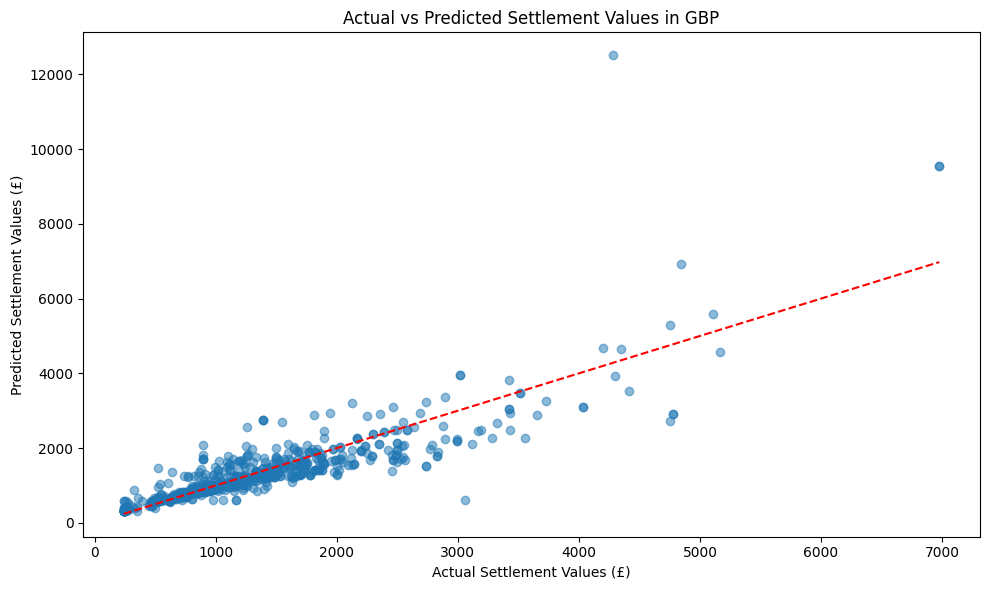

In [10]:
def evaluate_model_in_gbp(model, data_loader, device):
    """
    Enhanced evaluation function with value-range specific metrics
    """
    model.eval()
    actual_gbp = []
    predicted_gbp = []
    
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            predictions = model(X_batch)
            y_gbp = np.expm1(y_batch.cpu().numpy())
            pred_gbp = np.expm1(predictions.cpu().numpy())
    
            actual_gbp.extend(y_gbp)
            predicted_gbp.extend(pred_gbp)

    # Convert to arrays for easier manipulation
    actual_gbp = np.array(actual_gbp).flatten()
    predicted_gbp = np.array(predicted_gbp).flatten()
    
    # Calculate error metrics in GBP
    mse_gbp = mean_squared_error(actual_gbp, predicted_gbp)
    rmse_gbp = np.sqrt(mse_gbp)
    mae_gbp = mean_absolute_error(actual_gbp, predicted_gbp)
    mape_gbp = np.mean(np.abs((actual_gbp - predicted_gbp) / actual_gbp)) * 100
    r2_gbp = r2_score(actual_gbp, predicted_gbp)
    
    # Value range specific metrics
    low_values = actual_gbp < 1000
    mid_values = (actual_gbp >= 1000) & (actual_gbp < 3000)
    high_values = actual_gbp >= 3000
    
    low_mape = np.mean(np.abs((actual_gbp[low_values] - predicted_gbp[low_values]) / actual_gbp[low_values])) * 100 if any(low_values) else 0
    mid_mape = np.mean(np.abs((actual_gbp[mid_values] - predicted_gbp[mid_values]) / actual_gbp[mid_values])) * 100 if any(mid_values) else 0
    high_mape = np.mean(np.abs((actual_gbp[high_values] - predicted_gbp[high_values]) / actual_gbp[high_values])) * 100 if any(high_values) else 0
    
    print("Errors in GBP (£):")
    print(f"MSE: £{mse_gbp:.2f}")
    print(f"RMSE: £{rmse_gbp:.2f}")
    print(f"MAE: £{mae_gbp:.2f}")
    print(f"MAPE: {mape_gbp:.2f}%")
    print(f"R²: {r2_gbp:.4f}")
    print("\nValue range specific MAPE:")
    print(f"Low values (<£1000): {low_mape:.2f}%")
    print(f"Mid values (£1000-£3000): {mid_mape:.2f}%")
    print(f"High values (>£3000): {high_mape:.2f}%")
    
    return {
        'MSE_GBP': mse_gbp,
        'RMSE_GBP': rmse_gbp,
        'MAE_GBP': mae_gbp,
        'MAPE_GBP': mape_gbp,
        'R2_GBP': r2_gbp,
        'actual_gbp': actual_gbp,
        'predicted_gbp': predicted_gbp,
        'low_mape': low_mape,
        'mid_mape': mid_mape,
        'high_mape': high_mape
    }

# Call this function to evaluate on test set
gbp_metrics = evaluate_model_in_gbp(model, test_loader, device)

# Visualize predictions in GBP
plt.figure(figsize=(10, 6))
plt.scatter(gbp_metrics['actual_gbp'], gbp_metrics['predicted_gbp'], alpha=0.5)
plt.plot([min(gbp_metrics['actual_gbp']), max(gbp_metrics['actual_gbp'])], 
         [min(gbp_metrics['actual_gbp']), max(gbp_metrics['actual_gbp'])], 'r--')
plt.xlabel('Actual Settlement Values (£)')
plt.ylabel('Predicted Settlement Values (£)')
plt.title('Actual vs Predicted Settlement Values in GBP')
plt.tight_layout()
plt.show()

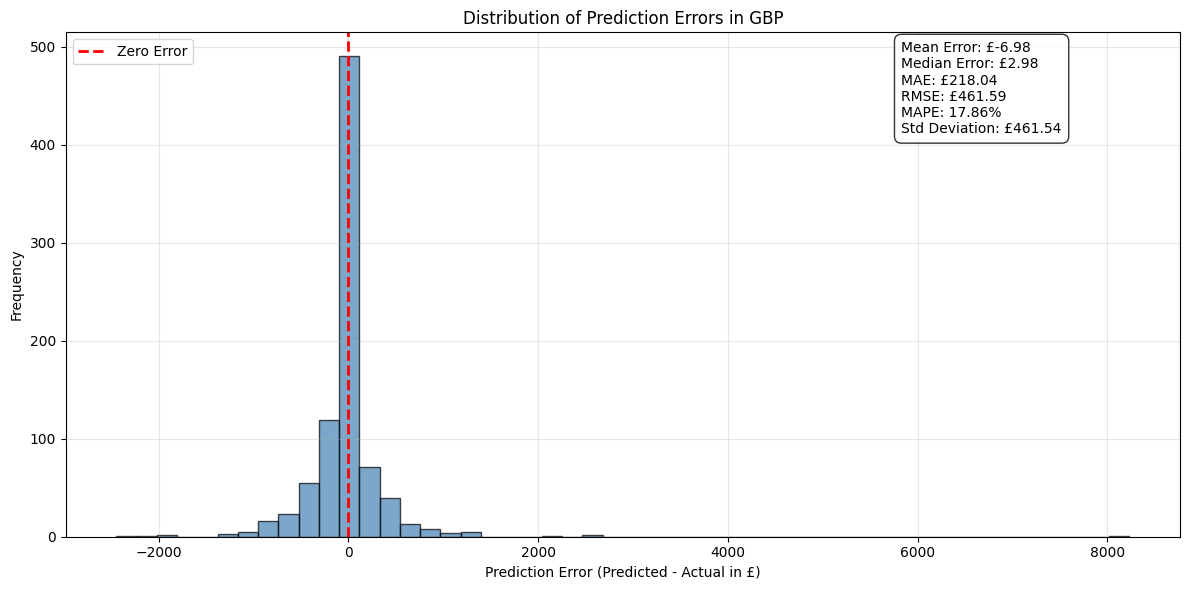

Error Analysis Complete!
Mean Absolute Error (MAE): £218.04
Root Mean Squared Error (RMSE): £461.59
Mean Absolute Percentage Error (MAPE): 17.86%


In [13]:
def analyze_prediction_errors_gbp(actual_gbp, predicted_gbp, figsize=(12, 6), bins=50, 
                                  color='steelblue', show_plot=True, save_path=None):
    """
    Analyze and visualize the errors between predicted and actual values in GBP (pounds).
    
    Parameters:
    -----------
    actual_gbp : array-like
        Actual settlement values in GBP
    predicted_gbp : array-like
        Predicted settlement values in GBP
    figsize : tuple, optional
        Figure size (width, height) in inches
    bins : int, optional
        Number of histogram bins
    color : str, optional
        Color for the histogram bars
    show_plot : bool, optional
        Whether to display the plot
    save_path : str, optional
        Path to save the figure (if None, figure is not saved)
        
    Returns:
    --------
    dict
        Dictionary containing error metrics (mean, median, std, MAE, RMSE)
    """
    # Convert inputs to numpy arrays if they aren't already
    actual_gbp = np.array(actual_gbp).flatten()
    predicted_gbp = np.array(predicted_gbp).flatten()
    
    # Calculate differences
    differences_gbp = predicted_gbp - actual_gbp
    
    # Calculate statistics
    mean_error = np.mean(differences_gbp)
    median_error = np.median(differences_gbp)
    std_error = np.std(differences_gbp)
    mae = np.mean(np.abs(differences_gbp))
    mse = np.mean(np.square(differences_gbp))
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs(differences_gbp / actual_gbp)) * 100
    
    # Create a histogram of the differences
    plt.figure(figsize=figsize)
    plt.hist(differences_gbp, bins=bins, alpha=0.7, color=color, edgecolor='black')
    plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
    
    # Add labels and title
    plt.xlabel('Prediction Error (Predicted - Actual in £)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Prediction Errors in GBP')
    
    # Add statistics to the plot
    stats_text = (f'Mean Error: £{mean_error:.2f}\n'
                  f'Median Error: £{median_error:.2f}\n'
                  f'MAE: £{mae:.2f}\n'
                  f'RMSE: £{rmse:.2f}\n'
                  f'MAPE: {mape:.2f}%\n'
                  f'Std Deviation: £{std_error:.2f}')
    
    plt.annotate(stats_text, xy=(0.75, 0.8), xycoords='axes fraction', 
                 bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8))
    
    plt.legend()
    plt.tight_layout()
    plt.grid(alpha=0.3)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    if show_plot:
        plt.show()
    else:
        plt.close()
    
    # Return error metrics as a dictionary
    return {
        'mean_error': mean_error,
        'median_error': median_error,
        'std_error': std_error,
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'mape': mape
    }

# Example usage - add this after evaluating your model with the evaluate_model_in_gbp function
error_metrics = analyze_prediction_errors_gbp(
    gbp_metrics['actual_gbp'], 
    gbp_metrics['predicted_gbp']
)

print("Error Analysis Complete!")
print(f"Mean Absolute Error (MAE): £{error_metrics['mae']:.2f}")
print(f"Root Mean Squared Error (RMSE): £{error_metrics['rmse']:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {error_metrics['mape']:.2f}%")

# Save Final Model

In [ ]:
# # # Save the model and related information
# torch.save({
#     'model_state_dict': model.state_dict(),
#     'top_10_features': top_10_features,
#     'feature_importance': best_feature_importance.head(10).to_dict('records'),
#     'best_feature_selection_model': best_model_name,
#     'input_size': input_size,
#     'performance_metrics': {
#         'mse_log': test_loss,
#         'r2_log': test_r2,
#         'mae_gbp': gbp_metrics['MAE_GBP'],
#         'rmse_gbp': gbp_metrics['RMSE_GBP'],
#         'mape_gbp': gbp_metrics['MAPE_GBP'],
#         'r2_gbp': gbp_metrics['R2_GBP']
#     }
# }, 'neural_network_top10_features.pth')

# print("Model trained on top 10 features saved to 'neural_network_top10_features.pth'")

In [ ]:
# Function to identify categorical and numerical columns (same as model_comparison.ipynb)
def identify_columns(data):
    # Identify categorical and numerical columns
    categorical_cols = data.select_dtypes(include=['object', 'string']).columns.tolist()
    numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    # Remove the target variable from the feature lists
    target_col = 'LogSettlementValue'
    
    # Remove both the log-transformed target AND the original settlement value from features
    if target_col in numerical_cols:
        numerical_cols.remove(target_col)
    if 'SettlementValue' in numerical_cols: 
        numerical_cols.remove('SettlementValue') 
    
    return categorical_cols, numerical_cols, target_col

# Define preprocessor function (similar to model_comparison.ipynb)
def define_preprocessor(data):
    categorical_cols, numerical_cols, _ = identify_columns(data)
    
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),  # Handle missing numerical values with median
        ('scaler', StandardScaler())                    # Standardize numerical features
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing categorical values
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ]
    )
    
    return preprocessor, numerical_cols, categorical_cols

# Get categorical and numerical columns
categorical_cols, numerical_cols, target_col = identify_columns(claim_data)
print(f"\nCategorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")
print(f"Target column: {target_col}")


Categorical columns: ['AccidentType', 'DominantInjury', 'VehicleType', 'WeatherConditions', 'AccidentDescription', 'InjuryDescription', 'Gender']
Numerical columns: ['InjuryPrognosis', 'SpecialHealthExpenses', 'SpecialReduction', 'SpecialOverage', 'GeneralRest', 'SpecialAdditionalInjury', 'SpecialEarningsLoss', 'SpecialUsageLoss', 'SpecialMedications', 'SpecialAssetDamage', 'SpecialRehabilitation', 'SpecialFixes', 'GeneralFixed', 'GeneralUplift', 'SpecialLoanerVehicle', 'SpecialTripCosts', 'SpecialJourneyExpenses', 'SpecialTherapy', 'ExceptionalCircumstances', 'MinorPsychologicalInjury', 'Whiplash', 'AccidentDate', 'ClaimDate', 'VehicleAge', 'DriverAge', 'NumberOfPassengers', 'PoliceReportFiled', 'WitnessPresent']
Target column: LogSettlementValue


# Transfer Learning for Insurance Settlement Model
Transfer learning mechanism to adapt the pre-trained neural network to new data.

In [ ]:

def load_pretrained_model(model_path):

    checkpoint = torch.load(model_path, weights_only=False)
    
    # Create a new model instance with the same architecture
    input_size = checkpoint['input_size']
    pretrained_model = InsuranceNN(input_size).to(device)
    
    # Load weights
    pretrained_model.load_state_dict(checkpoint['model_state_dict'])
    
    # Get feature information
    top_10_features = checkpoint['top_10_features']
    
    return pretrained_model, top_10_features, input_size

# Load the model we previously trained
pretrained_model, top_10_features, input_size = load_pretrained_model('neural_network_top10_features.pth')
print(f"Loaded pre-trained model with input size: {input_size}")
print(f"Top 10 features: {top_10_features}")

In [ ]:
# Simulate "new" data by taking a subset of test data and adding some modifications
# In a real scenario, you would load your actual new dataset here
def create_transfer_dataset(test_loader, modification_factor=0.15):
    X_transfer = []
    y_transfer = []
    
    # Get some data from the test set
    for X_batch, y_batch in test_loader:
        X_transfer.append(X_batch.clone())
        
        # Modify the target values slightly to simulate a shifted distribution
        # Add a percentage increase to represent a shift in the data distribution
        modified_y = y_batch * (1 + torch.randn_like(y_batch) * modification_factor)
        y_transfer.append(modified_y)
    
    # Concatenate all batches
    X_transfer = torch.cat(X_transfer)
    y_transfer = torch.cat(y_transfer)
    
    # Split into train/val
    indices = torch.randperm(len(X_transfer))
    train_size = int(0.8 * len(X_transfer))
    
    X_transfer_train = X_transfer[indices[:train_size]]
    y_transfer_train = y_transfer[indices[:train_size]]
    X_transfer_val = X_transfer[indices[train_size:]]
    y_transfer_val = y_transfer[indices[train_size:]]
    
    # Create data loaders
    transfer_train_dataset = TensorDataset(X_transfer_train, y_transfer_train)
    transfer_val_dataset = TensorDataset(X_transfer_val, y_transfer_val)
    
    transfer_train_loader = DataLoader(transfer_train_dataset, batch_size=16, shuffle=True)
    transfer_val_loader = DataLoader(transfer_val_dataset, batch_size=16, shuffle=False)
    
    return transfer_train_loader, transfer_val_loader

# Create modified transfer learning datasets
transfer_train_loader, transfer_val_loader = create_transfer_dataset(test_loader)

# Visualize the distribution shift
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
transfer_y = torch.cat([y for _, y in transfer_train_loader.dataset])
plt.hist(transfer_y.numpy(), bins=30, alpha=0.7, color='blue', label='Transfer')
plt.title('Transfer Target Distribution')

plt.subplot(1, 2, 2)
orig_y = torch.cat([y for _, y in train_dataset])
plt.hist(orig_y.numpy(), bins=30, alpha=0.7, color='green', label='Original')
plt.title('Original Target Distribution')

plt.tight_layout()
plt.show()

# 1. Simulate New Data (Transfer Domain)

In [ ]:
def prepare_transfer_learning(model):
    # Clone the model for fine-tuning
    transfer_model = copy.deepcopy(model)
    
    # Freeze most of the layers
    for name, param in transfer_model.named_parameters():
        # Only fine-tune the final layers and branches
        if not any(layer_name in name for layer_name in ['final', 'low_value_net', 'mid_value_net', 'high_value_net']):
            param.requires_grad = False
    
    # Count trainable vs frozen parameters
    trainable_params = sum(p.numel() for p in transfer_model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in transfer_model.parameters())
    
    print(f"Trainable parameters: {trainable_params} ({trainable_params/total_params:.1%})")
    print(f"Total parameters: {total_params}")
    
    return transfer_model

# Prepare model for transfer learning

transfer_model = prepare_transfer_learning(pretrained_model)

# Use a simpler loss function for fine-tuning
transfer_criterion = nn.MSELoss()

# Lower learning rate for fine-tuning
transfer_optimizer = optim.Adam(
    [p for p in transfer_model.parameters() if p.requires_grad], 
    lr=0.0002, 
    weight_decay=1e-5
)

# 2. Freeze Layers and Prepare for Fine-tuning

In [ ]:
def prepare_transfer_learning(model):
    # Clone the model for fine-tuning
    transfer_model = copy.deepcopy(model)
    
    # Freeze most of the layers
    for name, param in transfer_model.named_parameters():
        # Only fine-tune the final layers and branches
        if not any(layer_name in name for layer_name in ['final', 'low_value_net', 'mid_value_net', 'high_value_net']):
            param.requires_grad = False
    
    # Count trainable vs frozen parameters
    trainable_params = sum(p.numel() for p in transfer_model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in transfer_model.parameters())
    
    print(f"Trainable parameters: {trainable_params} ({trainable_params/total_params:.1%})")
    print(f"Total parameters: {total_params}")
    
    return transfer_model

# Prepare model for transfer learning

transfer_model = prepare_transfer_learning(pretrained_model)

# Use a simpler loss function for fine-tuning
transfer_criterion = nn.MSELoss()

# Lower learning rate for fine-tuning
transfer_optimizer = optim.Adam(
    [p for p in transfer_model.parameters() if p.requires_grad], 
    lr=0.0002, 
    weight_decay=1e-5
)

# 3. Training Loop

In [ ]:
# Fine-tuning loop
def fine_tune_model(model, optimizer, criterion, train_loader, val_loader, num_epochs=30):
    best_val_loss = float('inf')
    best_model_state = None
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # Forward pass
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * X_batch.size(0)
        
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                val_loss += loss.item() * X_batch.size(0)
        
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    # Plot training curve
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Transfer Learning Training Curve')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
    
    return model

# Fine-tune the model with transfer learning
fine_tuned_model = fine_tune_model(
    transfer_model, 
    transfer_optimizer, 
    transfer_criterion, 
    transfer_train_loader, 
    transfer_val_loader
)

# 4. Fine Tuning Training Loop

In [ ]:
# Evaluate the fine-tuned model on the transfer validation set
def evaluate_transferred_model(model, data_loader):
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            pred = model(X_batch)
            
            predictions.extend(pred.cpu().numpy())
            actuals.extend(y_batch.cpu().numpy())
            
    # Calculate metrics in log space
    mse = mean_squared_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    
    # Calculate metrics in original space
    actuals_gbp = np.expm1(actuals)
    predictions_gbp = np.expm1(predictions)
    
    mse_gbp = mean_squared_error(actuals_gbp, predictions_gbp)
    rmse_gbp = np.sqrt(mse_gbp)
    mae_gbp = mean_absolute_error(actuals_gbp, predictions_gbp)
    
    print("Fine-tuned Model Performance:")
    print(f"MSE (log space): {mse:.4f}")
    print(f"R² (log space): {r2:.4f}")
    print(f"RMSE (£): {rmse_gbp:.2f}")
    print(f"MAE (£): {mae_gbp:.2f}")
    
    # Return results for comparison
    return {
        'mse_log': mse,
        'r2_log': r2,
        'rmse_gbp': rmse_gbp,
        'mae_gbp': mae_gbp,
        'actuals': actuals,
        'predictions': predictions
    }

# Evaluate the fine-tuned model
fine_tuned_metrics = evaluate_transferred_model(fine_tuned_model, transfer_val_loader)

In [ ]:
# Compare the original and fine-tuned models on the transfer data
def compare_models(original_model, fine_tuned_model, data_loader):
    # Evaluate original model
    original_model.eval()
    orig_preds = []
    actuals = []
    
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            pred = original_model(X_batch)
            
            orig_preds.extend(pred.cpu().numpy())
            actuals.extend(y_batch.cpu().numpy())
    
    # Evaluate fine-tuned model
    fine_tuned_model.eval()
    ft_preds = []
    
    with torch.no_grad():
        for X_batch, _ in data_loader:
            X_batch = X_batch.to(device)
            pred = fine_tuned_model(X_batch)
            ft_preds.extend(pred.cpu().numpy())
    
    # Convert to GBP
    actuals_gbp = np.expm1(actuals)
    orig_preds_gbp = np.expm1(orig_preds)
    ft_preds_gbp = np.expm1(ft_preds)
    
    # Calculate metrics
    orig_mae = mean_absolute_error(actuals_gbp, orig_preds_gbp)
    ft_mae = mean_absolute_error(actuals_gbp, ft_preds_gbp)
    
    orig_rmse = np.sqrt(mean_squared_error(actuals_gbp, orig_preds_gbp))
    ft_rmse = np.sqrt(mean_squared_error(actuals_gbp, ft_preds_gbp))
    
    # Print comparison
    print("Model Comparison (on transfer data):")
    print(f"Original model MAE: £{orig_mae:.2f}, RMSE: £{orig_rmse:.2f}")
    print(f"Fine-tuned model MAE: £{ft_mae:.2f}, RMSE: £{ft_rmse:.2f}")
    print(f"Improvement in MAE: £{orig_mae - ft_mae:.2f} ({(orig_mae - ft_mae)/orig_mae:.1%})")
    print(f"Improvement in RMSE: £{orig_rmse - ft_rmse:.2f} ({(orig_rmse - ft_rmse)/orig_rmse:.1%})")
    
    # Plot comparison
    plt.figure(figsize=(12, 5))
    
    # Plot 1: Scatter comparison
    plt.subplot(1, 2, 1)
    plt.scatter(actuals_gbp, orig_preds_gbp, alpha=0.5, color='blue', label='Original')
    plt.scatter(actuals_gbp, ft_preds_gbp, alpha=0.5, color='red', label='Fine-tuned')
    plt.plot([min(actuals_gbp), max(actuals_gbp)], 
             [min(actuals_gbp), max(actuals_gbp)], 'k--')
    plt.xlabel('Actual Settlement Values (£)')
    plt.ylabel('Predicted Settlement Values (£)')
    plt.title('Prediction Comparison')
    plt.legend()
    
    # Plot 2: Error distribution comparison
    plt.subplot(1, 2, 2)
    orig_errors = orig_preds_gbp - actuals_gbp
    ft_errors = ft_preds_gbp - actuals_gbp
    
    plt.hist(orig_errors, bins=30, alpha=0.5, color='blue', label='Original')
    plt.hist(ft_errors, bins=30, alpha=0.5, color='red', label='Fine-tuned')
    plt.axvline(0, color='black', linestyle='--')
    plt.xlabel('Error (£)')
    plt.ylabel('Frequency')
    plt.title('Error Distribution')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Compare original and fine-tuned models
compare_models(pretrained_model, fine_tuned_model, transfer_val_loader)

# 5. Save fine tuning

In [ ]:
# Save the fine-tuned model
torch.save({
    'model_state_dict': fine_tuned_model.state_dict(),
    'top_10_features': top_10_features,
    'input_size': input_size,
    'performance_metrics': {
        'mse_log': fine_tuned_metrics['mse_log'],
        'r2_log': fine_tuned_metrics['r2_log'],
        'rmse_gbp': fine_tuned_metrics['rmse_gbp'],
        'mae_gbp': fine_tuned_metrics['mae_gbp']
    }
}, 'fine_tuned_neural_network.pth')